### [Regression Data Analysis]
# KaKR House Price Prediction - Linear Models Scoring Comparison

- 데이터셋을 이용하여 이번에는 Linear 기반 여러가지 모델을 통해 각 feature의 유효성을 확인합니다.


- Linear Model 에서는 feature의 scale, 종류에 대해 예민하게 반응하므로 여러가지 시도를 해봅니다. 


- 각 모델별로도 비교하여 어떤 모델이 좋은지 확인합니다.

---

#### Import Modules

In [214]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import skew

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inlinerow_data = pd.read_csv("./data/train.csv", index_col=['id'])
row_test = pd.read_csv("./data/test.csv", index_col=['id'])

row_data.shape, row_test.shape

((15035, 20), (6468, 19))

#### Utility Functions

In [328]:
def feature_preprocess(row_data, zipcode_rank_dict):
    
    data = row_data.copy()
    
    # price log transformation
    if 'price' in data.columns:
        data['log_price'] = np.log1p(data.price)
    
    # Date parsing
    data['date'] = data['date'].apply(lambda i: i[:8])
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    data['day']= data.date.dt.day
    data['year_month'] = data.date.dt.year * 100 + data.date.dt.month
    data['day_of_week'] = data.date.dt.dayofweek
    data['2015_or_not'] = data.year.apply(lambda i: 0 if i == 2014 else 1)
    data['weekday_ohe'] = data.day_of_week.apply(lambda i: 1 if i in range(5) else 0)
    data['saturday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 5 else 0)
    data['sunday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 6 else 0)
    
    # yr_renovated
    data['yr_renovated_ohe'] = data['yr_renovated'].apply(lambda i: 0 if i == 0 else 1)
    
    # zipcode : 위에서 zipcode_rank_dict를 만들어놔야 코드가 실행됨
    data['zipcode_rank'] = 71 - data['zipcode'].apply(lambda i: zipcode_rank_dict[i])
    
    # lat / long
    data['lat_scale'] = (data['lat'] - data['lat'].mean()) / data['lat'].std()
    data['long_scale'] = (data['long'] - data['long'].mean()) / data['long'].std()
    
    # areas
    data['sqft_living_scale'] = np.log1p(data['sqft_living'])
    data['sqft_lot_scale'] = np.log1p(data['sqft_lot'])
    data['sqft_living15_scale'] = np.log1p(data['sqft_living15'])
    data['sqft_lot15_scale'] = np.log1p(data['sqft_lot15'])
    data['sqft_living_diff'] = data['sqft_living15'] - data['sqft_living']
    data['sqft_lot_diff'] = data['sqft_lot15'] - data['sqft_lot']
    data.loc[data['sqft_living_diff'] < 0, 'sqft_living_diff_scale'] = -np.log1p(-data['sqft_living_diff'])
    data.loc[data['sqft_living_diff'] >= 0, 'sqft_living_diff_scale'] = np.log1p(data['sqft_living_diff'])
    data.loc[data['sqft_lot_diff'] < 0, 'sqft_lot_diff_scale'] = -np.log1p(-data['sqft_lot_diff'])
    data.loc[data['sqft_lot_diff'] >= 0, 'sqft_lot_diff_scale'] = np.log1p(data['sqft_lot_diff'])
    data['sqft_above_scale'] = np.log1p(data['sqft_above'])
    data['sqft_basement_scale'] = np.log1p(data['sqft_basement'])
    data['sqft_basement_ohe'] = data.sqft_basement.apply(lambda i: 0 if i == 0 else 1)
    
    return data

In [329]:
def get_ziprank(data):
    zipcode_rank = data.groupby(['zipcode']).mean().sort_values(by=['price'], \
                                                                ascending=False).reset_index()[['zipcode', 'price']]
    zipcode_rank['rank'] = range(1, len(zipcode_rank)+1)
    zipcode_rank_dict = zipcode_rank.set_index(['zipcode'])['rank'].to_dict()
    
    return zipcode_rank_dict

In [330]:
zipcode_rank_dict = get_ziprank(row_data)

In [331]:
data = feature_preprocess(row_data, zipcode_rank_dict)
test = feature_preprocess(row_test, zipcode_rank_dict)

data.shape, test.shape

((15035, 45), (6468, 43))

In [332]:
set(data.columns) - set(test.columns)

{'log_price', 'price'}

In [458]:
def transform_skewness(data):
    
    data_skew = data.copy()
    
    def year_month_scaling(year_month):
        result = 1
        
        if year_month == 201405:
            return result
        elif year_month == 201406:
            return result + 1
        elif year_month == 201407:
            return result + 2
        elif year_month == 201408:
            return result + 3
        elif year_month == 201409:
            return result + 4
        elif year_month == 201410:
            return result + 5
        elif year_month == 201411:
            return result + 6
        elif year_month == 201412:
            return result + 7
        elif year_month == 201501:
            return result + 8
        elif year_month == 201502:
            return result + 9
        elif year_month == 201503:
            return result + 10
        elif year_month == 201504:
            return result + 11
        elif year_month == 201505:
            return result + 12
    
    data_skew['year_month_scale'] = data.year_month.apply(year_month_scaling)
    data_skew['bedrooms_scale'] = np.log1p(data.bedrooms)
    data_skew['bathrooms_scale'] = np.log1p(data.bathrooms)
    data_skew['floors_scale'] = np.log1p(data.floors)
    data_skew['grade_scale'] = np.exp((data['grade'] - data.grade.min()) \
                                 / (data.grade.max() - data.grade.min()))
    data_skew['zipcode_rank_scale'] = np.exp((data['zipcode_rank'] - data.zipcode_rank.min()) \
                                        / (data.zipcode_rank.max() - data.zipcode_rank.min()))
    data_skew['yr_built_scale'] = (data.yr_built - data.yr_built.min()) \
                                    / (data.yr_built.max() - data.yr_built.min())
    data_skew['yr_renovated_scale'] = (data.yr_renovated - data.yr_renovated.min()) \
                                    / (data.yr_renovated.max() - data.yr_renovated.min())
    
    return data_skew

In [459]:
data = transform_skewness(data)
test = transform_skewness(test)

In [8]:
def rmsle_cv(model, train, label):
    rmse_list = np.sqrt(-cross_val_score(model, train, label, scoring='neg_mean_squared_error', cv=5))
    
    return np.round(np.mean(rmse_list), 4)

In [9]:
def r2_cv(model, train, label):
    r2_list = cross_val_score(model, train, label, scoring='r2', cv=5)
    
    return np.round(np.mean(r2_list), 4)

In [10]:
def rmse(model, y_test, y_pred):

    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [23]:
def get_scores(models, train, label, rmse_=True):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        df[model_name] = []
        df[model_name].append(rmsle_cv(model, train, label))
        df[model_name].append(r2_cv(model, train, label))
        
        if rmse_:
            X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            df[model_name].append(rmse(model, y_test, y_pred))
        
        if rmse_:
            score_df = pd.DataFrame(df, index=['RMSLE', 'R2 score', 'RMSE']).T.sort_values('R2 score', \
                                                                                           ascending=False)
        else:
            score_df = pd.DataFrame(df, index=['RMSLE', 'R2 score']).T.sort_values('R2 score', \
                                                                                   ascending=False)
            
    return score_df

In [38]:
def get_coef(models, sort_model):
    coef = {}
    
    if type(models) != list:
        model = models
        model_name = model.__class__.__name__
        coef[model_name] = model.coef_
    
    else:
        for model in models:
            model_name = model.__class__.__name__
            coef[model_name] = model.coef_

    coef_df = pd.DataFrame(coef, index=train.columns)
    
    return coef_df.sort_values(sort_model.__class__.__name__, ascending=False)

In [54]:
def draw_coefs(models):
    if type(models) != list:
        plt.figure(figsize=(8, 6))
        model = models
        model_name = model.__class__.__name__
        sns.barplot(x=get_coef(models, model)[model_name].values, \
                    y=get_coef(models, model)[model_name].index).set_title(model_name)
            
    elif len(models) == 3:
        figure, axs = plt.subplots(nrows=1, ncols=3)
        figure.set_size_inches(18, 6)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            sns.barplot(x=get_coef(models, model)[model_name].values, \
                        y=get_coef(models, model)[model_name].index, \
                        ax=axs[idx]).set_title(model_name)
    else:
        figure, axs = plt.subplots(nrows=2, ncols=2)
        figure.set_size_inches(18, 12)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            sns.barplot(x=get_coef(models, model)[model_name].values, \
                        y=get_coef(models, model)[model_name].index, \
                        ax=axs[idx//2][idx%2]).set_title(model_name)
    
    plt.show()

In [14]:
def draw_importances(models, data):
    if type(models) != list:
        model = models
        model_name = model.__class__.__name__
        importances = [i for i in zip(data.columns, model.feature_importances_)]
        importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
        plt.figure(figsize=(8, 6))
        sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances]).set_title(model_name)
    
    elif len(models) == 3:
        figure, axs = plt.subplots(nrows=1, ncols=3)
        figure.set_size_inches(18, 6)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            importances = [i for i in zip(train.columns, model.feature_importances_)]
            importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
            sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances], \
                        ax=axs[idx]).set_title(model_name)

    else:
        figure, axs = plt.subplots(nrows=2, ncols=2)
        figure.set_size_inches(18, 12)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            importances = [i for i in zip(train.columns, model.feature_importances_)]
            importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
            sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances], \
                        ax=axs[idx//2][idx%2]).set_title(model_name)

    plt.show()

In [15]:
def BlendingModels(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [16]:
def LetSubmit(y_pred, filename):
    submission = pd.read_csv("./data/sample_submission.csv")
    submission['price'] = y_pred
    submission.to_csv("./submission/{}.csv".format(filename), index_label=False, index=False)
    submission_test = pd.read_csv("./submission.csv")
    
    return submission_test

In [17]:
def BestParamsGrid(model, train, label, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, label)
    rmsle = np.sqrt(-1 * grid_model.best_score_)
    params_df = pd.DataFrame(grid_model.best_params_, index=[grid_model.__class__.__name__]).T

    return grid_model, grid_model.best_params_, rmsle

---

## \#SUBMISSION 1 : row data

- 가장 먼저 아무것도 건들지 않은 row data로 돌려봅니다.

In [43]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
                'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
                'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

train = data[features]

In [44]:
label = data['price']

In [45]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [46]:
%%time
row_scores = get_scores(models, train, label, rmse_=False)

CPU times: user 7.74 s, sys: 2.03 s, total: 9.77 s
Wall time: 3.08 s


In [47]:
row_scores

,RMSLE,R2 score
LinearRegression,205223.4818,0.6936
Ridge,205220.3373,0.6936
Lasso,205223.6918,0.6936


- 그냥 봐도 Boosting 모델로 돌렸던 점수보다는 한참 낮음

In [48]:
X_train, X_test, y_train, y_test = train_test_split(row_train, row_label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_pred, y_test)))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  216325.59348015132
R2 score:  0.5042143455492121


In [59]:
ridge.fit(train, label)
lasso.fit(train, label)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

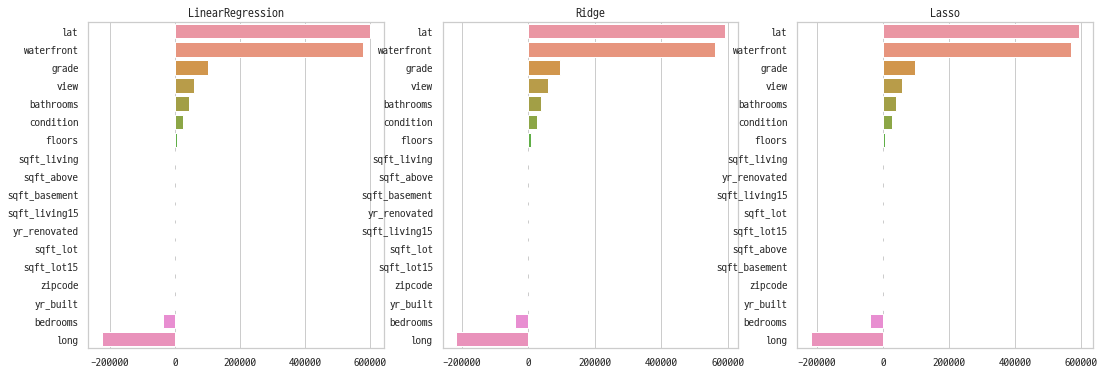

In [60]:
draw_coefs(models)

- 계수가 전체적으로 제대로 생성되지 않았으므로, feature 손 볼 필요 있음

---

## \#SUBMISSION 2 : `price` log변환

- 왜곡된 분포를 가졌던 price에만 log변환을 해본다.

In [69]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

train = data[features]

In [70]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [71]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [72]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 548 ms, sys: 947 ms, total: 1.49 s
Wall time: 248 ms


In [73]:
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.2532,0.7687,196862.165389
Ridge,0.2532,0.7687,181329.072491
Lasso,0.3594,0.5338,468841.118630


- log변환만으로 차이가 많이 난다

In [84]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  247300.15163306126
R2 score:  0.7161669348145545


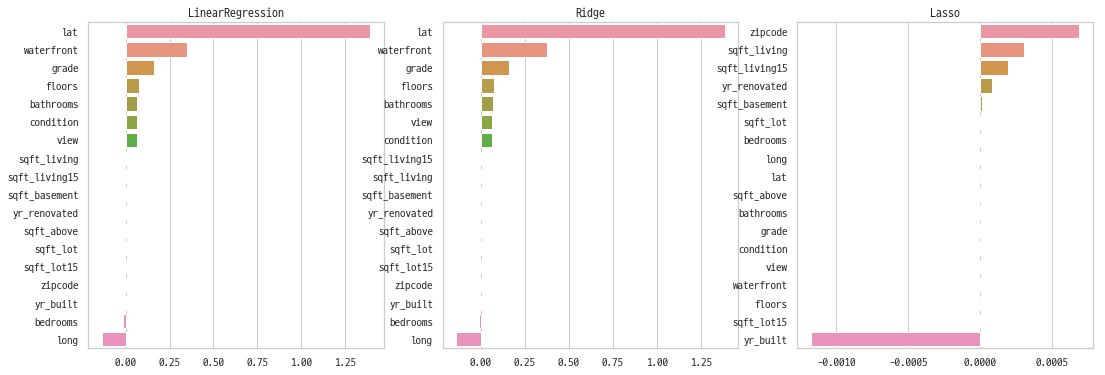

In [78]:
draw_coefs(models)

---

## \#SUBMISSION 3 : `price` log변환 + `zipcode_rank`

- 원래의 `zipcode` 대신 rank별로 전처리했던 `zipcode_rank` 컬럼을 넣는다.

In [94]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode_rank', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

train = data[features]

In [95]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [96]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [97]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 758 ms, sys: 1.04 s, total: 1.8 s
Wall time: 306 ms


In [98]:
# zipcode_rank
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.2025,0.8521,270563.865251
Ridge,0.2025,0.8521,209974.610284
Lasso,0.2507,0.7734,373853.857683


- 많은 차이가 난다!

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  133807.80289143152
R2 score:  0.8285010060261354


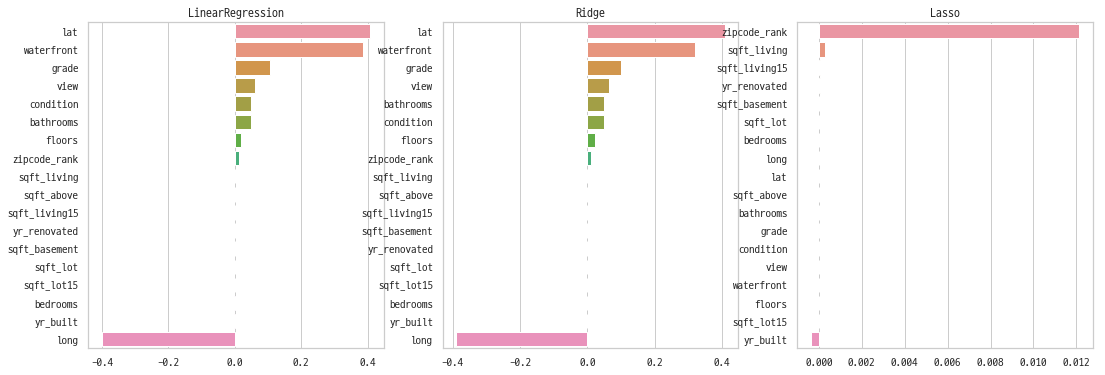

In [100]:
draw_coefs(models)

---

## \#SUBMISSION 4 : `price` log변환 + `zipcode_rank_scale`

- `zipcode_rank`를 scaling 해서 한 번 더 전처리한 컬럼을 넣는다.

In [145]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode_rank_scale', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


train = data[features]

In [146]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [147]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [148]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 1.12 s, sys: 588 ms, total: 1.71 s
Wall time: 196 ms


In [149]:
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.2050,0.8484,153744.763375
Ridge,0.2050,0.8484,151000.559728
Lasso,0.3619,0.5270,239663.448400


- `zipcode_rank_scale`은 오히려 떨어뜨린다

In [151]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  211880.3570414424
R2 score:  0.8335676528369034


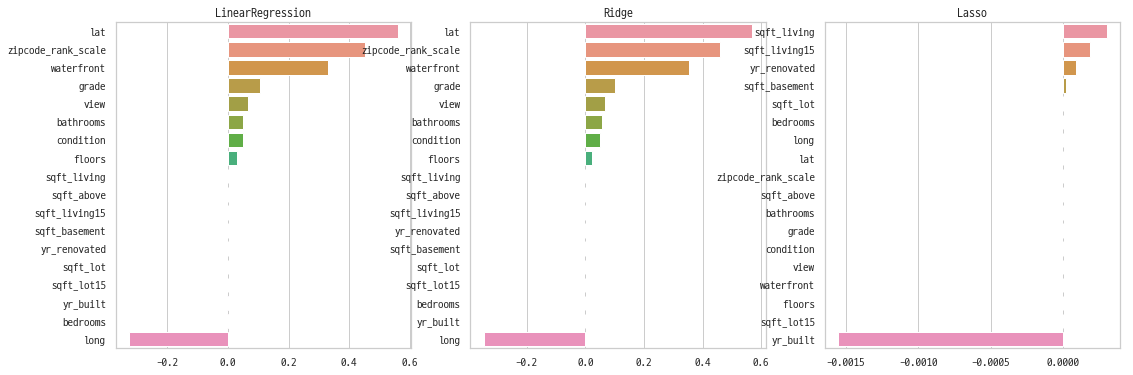

In [152]:
draw_coefs(models)

---

## \#SUBMISSION 5 : `price` log변환 + `zipcode_rank` + `2015_or_not` + `year_month`

- `2015_or_not` , `year_month`는 각각 하나씩 했을 때와 둘 다 넣었을 때 성능이 똑같다. 둘 다 넣기로 함 일단

In [244]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode_rank', 'lat', 'long', 'sqft_living15', 'sqft_lot15', '2015_or_not', 'year_month_scale']


train = data[features]

In [245]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [246]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [247]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 927 ms, sys: 814 ms, total: 1.74 s
Wall time: 220 ms


In [248]:
# zipcode_rank + year_month_scale + 2015_or_not
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.2010,0.8542,248981.859047
Ridge,0.2010,0.8542,171817.104157
Lasso,0.2507,0.7734,242814.656937


- 효과 있고!

In [249]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  188296.62236525526
R2 score:  0.8304151819326792


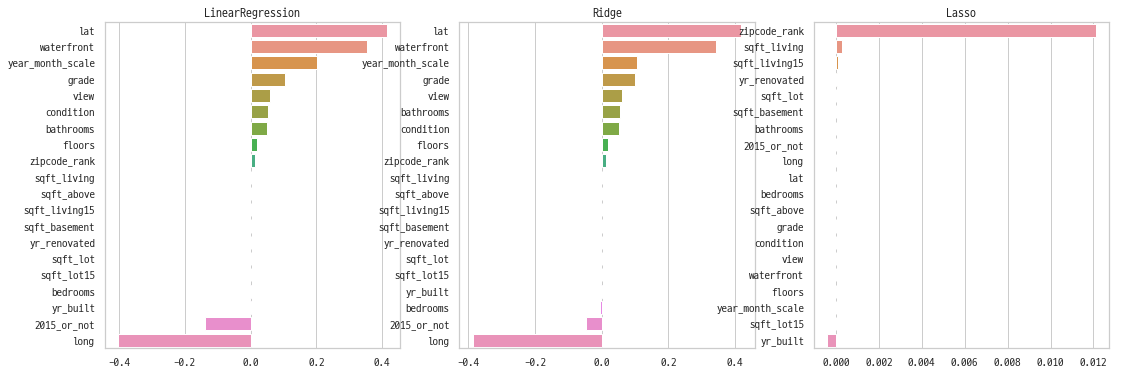

In [250]:
draw_coefs(models)

---

## \#SUBMISSION 6 : 5번에 plus
### + `sqft_living_scale`, `sqft_lot_scale`, `sqft_living15_scale` + `sqft_lot15_scale`

- 더 많은 컬럼들, 주로 area 면적 컬럼을 더 scaling한다.

In [278]:
features = ['bedrooms', 'bathrooms', 'sqft_living_scale', 'sqft_lot_scale', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode_rank', 'lat', 'long', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']


train = data[features]

In [279]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [280]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [281]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 974 ms, sys: 716 ms, total: 1.69 s
Wall time: 205 ms


In [282]:
# zipcode_rank + living_scale + lot_scale + living15_scale + lot15_scale
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1985,0.8579,141586.514982
Ridge,0.1985,0.8579,147464.263133
Lasso,0.2516,0.7717,446872.207562


- 효과 있고!

In [283]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  141915.80452438747
R2 score:  0.832521378549555


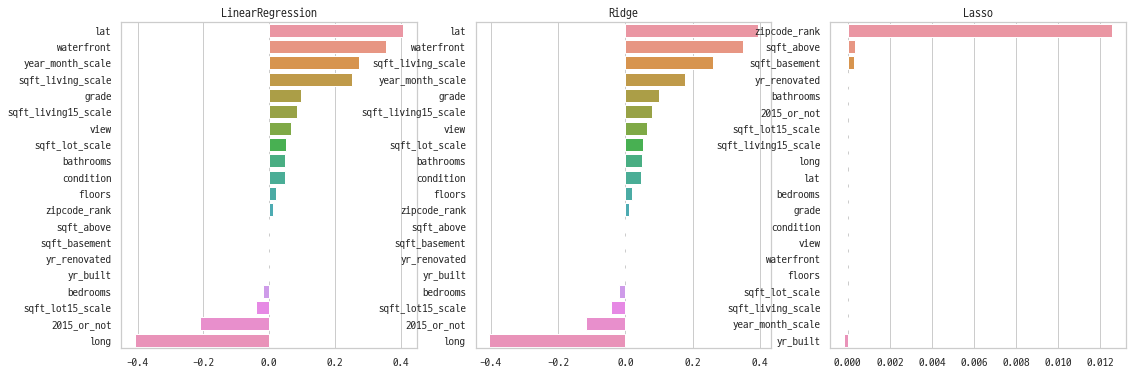

In [284]:
draw_coefs(models)

- 계수가 꽤 많이 생겨난 것을 볼 수 있다.

---

## \#SUBMISSION 7 : 5번에 plus
### + `sqft_living_scale`, `sqft_lot_scale`, `sqft_living15_scale` + `sqft_lot15_scale`
### + `lat_scale` + `long_scale`

In [285]:
features = ['bedrooms', 'bathrooms', 'sqft_living_scale', 'sqft_lot_scale', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode_rank', 'lat_scale', 'long_scale', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']


train = data[features]

In [286]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [287]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [288]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 1.05 s, sys: 645 ms, total: 1.69 s
Wall time: 199 ms


In [289]:
# zipcode_rank + area_scale + latlong_scale
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1985,0.8579,139028.296501
Ridge,0.1985,0.8579,146543.333382
Lasso,0.2516,0.7717,438398.973706


In [290]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  147779.40360537372
R2 score:  0.8401321901073073


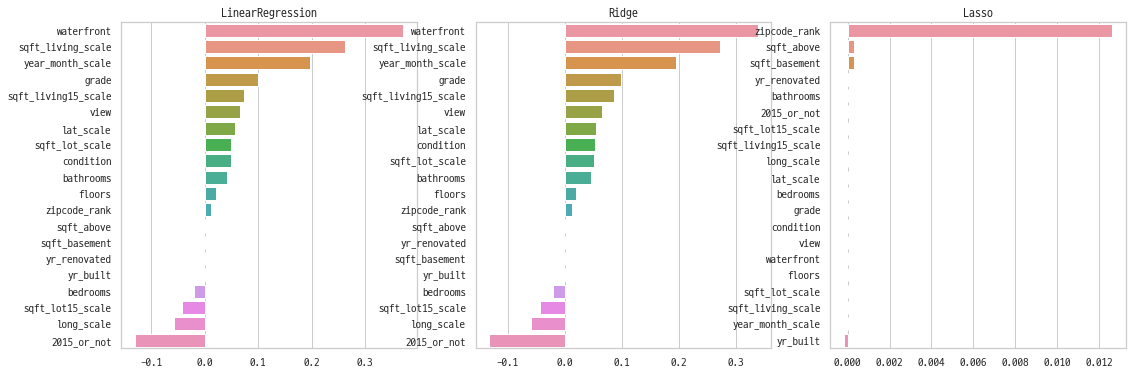

In [291]:
draw_coefs(models)

- 점수가 직접적으로 오르진 않았으나 계수가 너무 큰 것이 조정된 듯
- scaling 하는 게 맞냐, 아니냐?

---

## \#SUBMISSION 8 : 5번에 plus
### + `sqft_living_scale`, `sqft_lot_scale`, `sqft_living15_scale` + `sqft_lot15_scale`
### + `lat_scale` + `long_scale`
### + `yr_built_scale` + `yr_renovated_scale`

In [474]:
features = ['bedrooms', 'bathrooms', 'sqft_living_scale', 'sqft_lot_scale', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built_scale', 'yr_renovated_scale', \
            'zipcode_rank', 'lat_scale', 'long_scale', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']


train = data[features]

In [475]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [476]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [477]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 574 ms, sys: 939 ms, total: 1.51 s
Wall time: 286 ms


In [478]:
# zipcode_rank + area_scale + latlong_scale + yr_scale
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1985,0.8579,138496.001722
Ridge,0.1985,0.8579,137299.789657
Lasso,0.2534,0.7685,184564.884453


In [479]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  142049.89370035165
R2 score:  0.8221760723839471


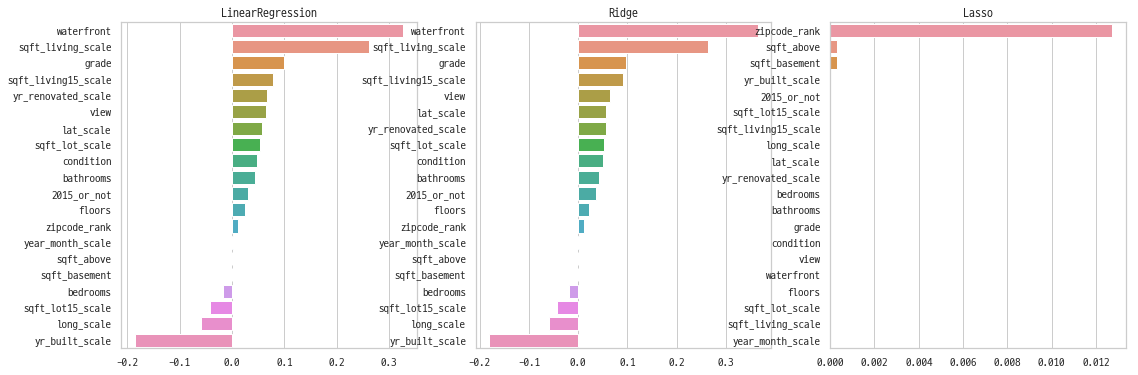

In [480]:
draw_coefs(models)

- 계수들이 점점 생기고 있다. feature들이 의미를 가진다는 말로 해석해도 되겠지

---

## \#SUBMISSION 9 : 5번에 plus
### + `sqft_living_scale`, `sqft_lot_scale`, `sqft_living15_scale` + `sqft_lot15_scale`
### + `lat_scale` + `long_scale`
### + `yr_built_scale` + `yr_renovated_scale`
### + `sqft_above_scale` + `sqft_basement_scale`

In [393]:
features = ['bedrooms', 'bathrooms', 'sqft_living_scale', 'sqft_lot_scale', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above_scale', 'sqft_basement_scale', 'yr_built_scale', 'yr_renovated_scale', \
            'zipcode_rank', 'lat_scale', 'long_scale', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']


train = data[features]

In [394]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [395]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [396]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 681 ms, sys: 901 ms, total: 1.58 s
Wall time: 211 ms


In [397]:
# zipcode_rank + area_scale + latlong_scale + yr_scale + above_basement_scale
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1994,0.8565,144229.374894
Ridge,0.1994,0.8565,133759.070748
Lasso,0.3734,0.4968,286678.739089


- `above`, `basement`들은 scaling하면 성능이 오히려 떨어진다. 
- 그렇다고 빼도 떨어지고, area feature들은 하나라도 빼면 성능이 떨어짐. 
- living과 living15 같은경우에는 상관성이 높아서 다중공선성 문제가 있을 수도 있는데, 왜?

In [392]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  146149.54217530243
R2 score:  0.8338488144621332


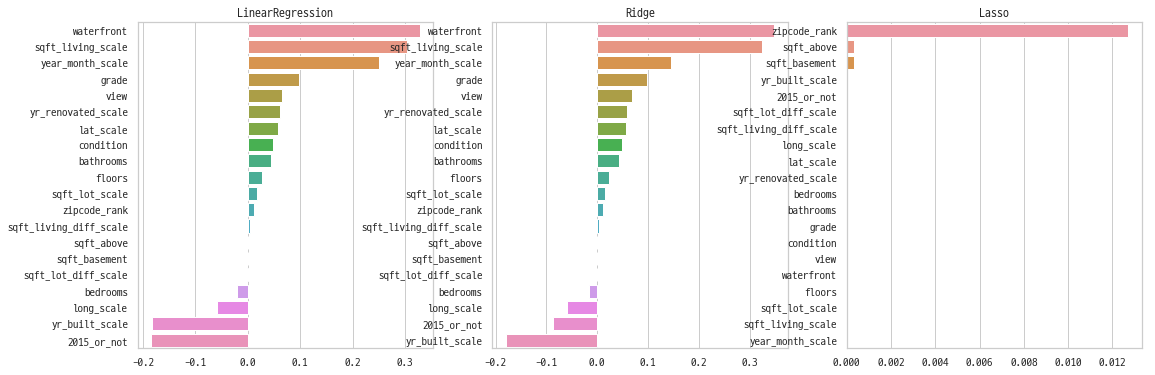

In [386]:
draw_coefs(models)

---

## \#SUBMISSION 10 : 5번에 plus
### + `sqft_living_scale`, `sqft_lot_scale`, `sqft_living15_scale` + `sqft_lot15_scale`
### + `lat_scale` + `long_scale`
### + `yr_built_scale` + `yr_renovated_scale`
### + grade, bedrooms, bathrooms, floors scale

- grade, bathrooms는 오히려 scale한 값을 넣으면 성능 떨어짐
- bedroom, floors는 의미 없음

In [436]:
features = ['bedrooms_scale', 'bathrooms_scale', 'sqft_living_scale', 'sqft_lot_scale', 'floors_scale', \
            'waterfront', 'view', \
            'condition', 'grade_scale', 'sqft_above', 'sqft_basement', 'yr_built_scale', 'yr_renovated_scale', \
            'zipcode_rank', 'lat_scale', 'long_scale', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']


train = data[features]

In [437]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [438]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [439]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 1.03 s, sys: 684 ms, total: 1.71 s
Wall time: 204 ms


In [440]:
# zipcode_rank + area_scale + latlong_scale + yr_scale
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1987,0.8577,147455.769778
Ridge,0.1987,0.8577,143860.602024
Lasso,0.2534,0.7685,186361.981575


In [441]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  146995.1903269443
R2 score:  0.839765706123432


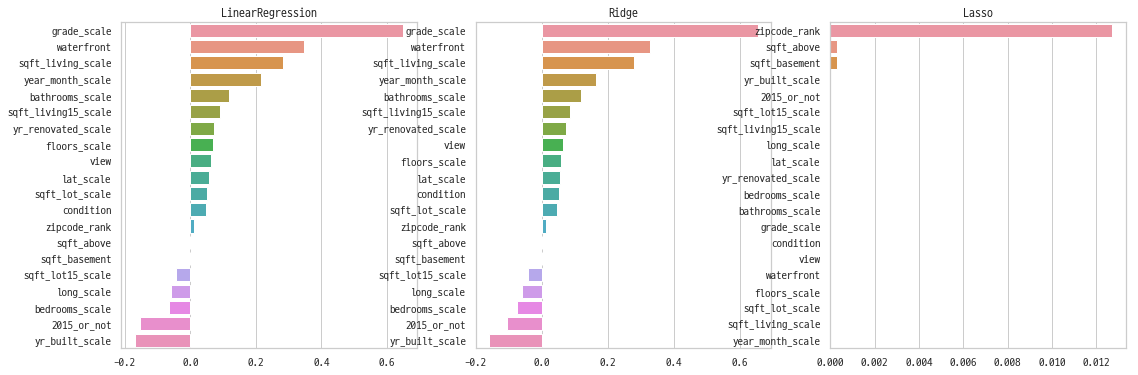

In [442]:
draw_coefs(models)

---

## \#SUBMISSION 11 : 8번 + outlier 삭제

- outlier를 삭제해본다.

In [445]:
features = ['bedrooms', 'bathrooms', 'sqft_living_scale', 'sqft_lot_scale', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built_scale', 'yr_renovated_scale', \
            'zipcode_rank', 'lat_scale', 'long_scale', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']

train = data[features]

In [446]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

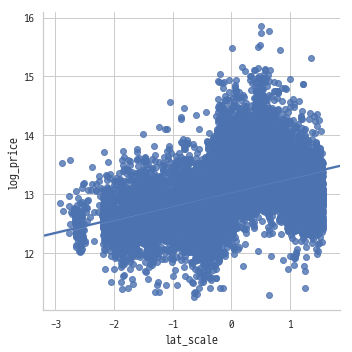

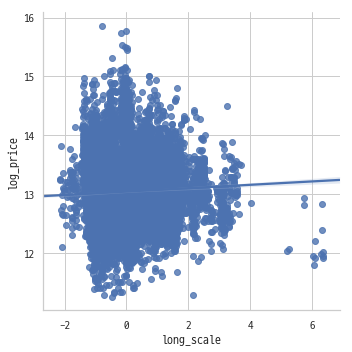

In [483]:
sns.lmplot(data=data, x='lat_scale', y='log_price')
sns.lmplot(data=data, x='long_scale', y='log_price')
plt.show()

In [484]:
len(data[data['long_scale'] > 4.2])

14

In [485]:
outliers = list(data[data['long_scale'] > 4.2].index)
outliers

[1853,
 2090,
 2988,
 4147,
 4298,
 7067,
 7607,
 9111,
 9237,
 9748,
 10199,
 11731,
 13668,
 13900]

- 14개의 outlier 삭제

In [486]:
print(train.shape, label.shape)
train = train.drop(outliers)
label = label.drop(outliers)
print(train.shape, label.shape)

(15035, 20) (15035,)
(15021, 20) (15021,)


In [487]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [488]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 569 ms, sys: 918 ms, total: 1.49 s
Wall time: 258 ms


In [489]:
# 8번 + outlier 제거
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1984,0.8578,134603.061363
Ridge,0.1984,0.8578,149564.054768
Lasso,0.2529,0.7691,191048.605417


- RMSLE가 줄었다고 할 수 있는가 ...

In [490]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  161994.68268728553
R2 score:  0.8500188890216906


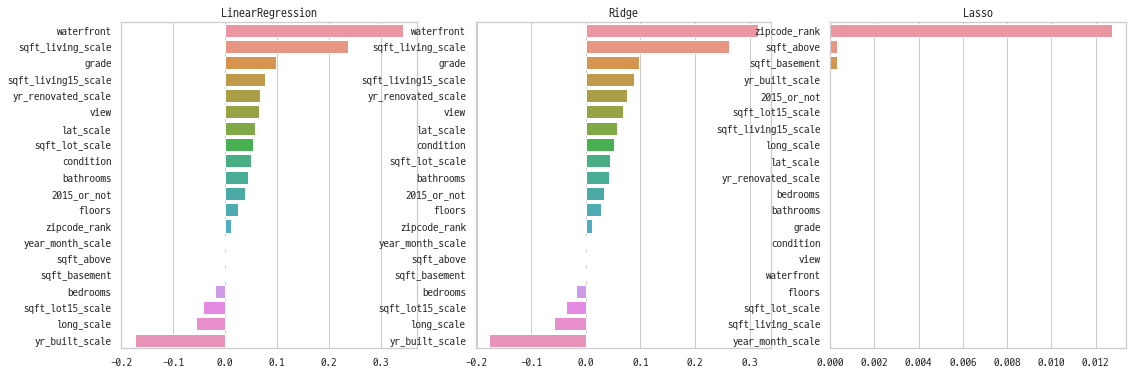

In [491]:
draw_coefs(models)

---

## \#SUBMISSION 12 : 11번 + Hyper Parameter Tuning

- Ridge와 Lasso 모델의 알파값을 튜닝해보자.

In [499]:
features = ['bedrooms', 'bathrooms', 'sqft_living_scale', 'sqft_lot_scale', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built_scale', 'yr_renovated_scale', \
            'zipcode_rank', 'lat_scale', 'long_scale', 'sqft_living15_scale', 'sqft_lot15_scale', \
            '2015_or_not', 'year_month_scale']

train = data[features]

In [500]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [501]:
outliers = list(data[data['long_scale'] > 4.2].index)

In [502]:
print(train.shape, label.shape)
train = train.drop(outliers)
label = label.drop(outliers)
print(train.shape, label.shape)

(15035, 20) (15035,)
(15021, 20) (15021,)


In [503]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [linear, ridge, lasso]

In [528]:
def BestParamsGrid(model, train, label, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, label)
    rmsle = np.sqrt(-1 * grid_model.best_score_)
    result = grid_model.cv_results_
    result['RMSLE'] = np.sqrt(-1 * grid_model.cv_results_['mean_test_score'])
    params_df = pd.DataFrame(result)

    return grid_model, params_df[['params', 'RMSLE']].sort_values('RMSLE'), rmsle

In [536]:
param_grid = {
    'alpha': [4.5, 5, 5.5]
}

grid_model, params_df, rmsle = BestParamsGrid(ridge, train, label, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.2s finished


In [537]:
params_df

,params,RMSLE
1,{'alpha': 5},0.198409
0,{'alpha': 4.5},0.198409
2,{'alpha': 5.5},0.198410


In [548]:
param_grid = {
    'alpha': [0.00005, 0.00006, 0.00007, 0.00008]
}

grid_model, params_df, rmsle = BestParamsGrid(lasso, train, label, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.5s finished


In [549]:
params_df

,params,RMSLE
1,{'alpha': 6e-05},0.198416
0,{'alpha': 5e-05},0.198416
2,{'alpha': 7e-05},0.198416
3,{'alpha': 8e-05},0.198416


In [550]:
linear = LinearRegression()
ridge = Ridge(alpha=5)
lasso = Lasso(alpha=0.00006)

models = [linear, ridge, lasso]

In [551]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 1.84 s, sys: 1.18 s, total: 3.01 s
Wall time: 484 ms


In [552]:
# 8번 + outlier 제거
row_scores

,RMSLE,R2 score,RMSE
LinearRegression,0.1984,0.8578,142256.786829
Ridge,0.1984,0.8578,166603.070925
Lasso,0.1984,0.8578,170691.641770


In [553]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  145534.61478240864
R2 score:  0.8481118045144672


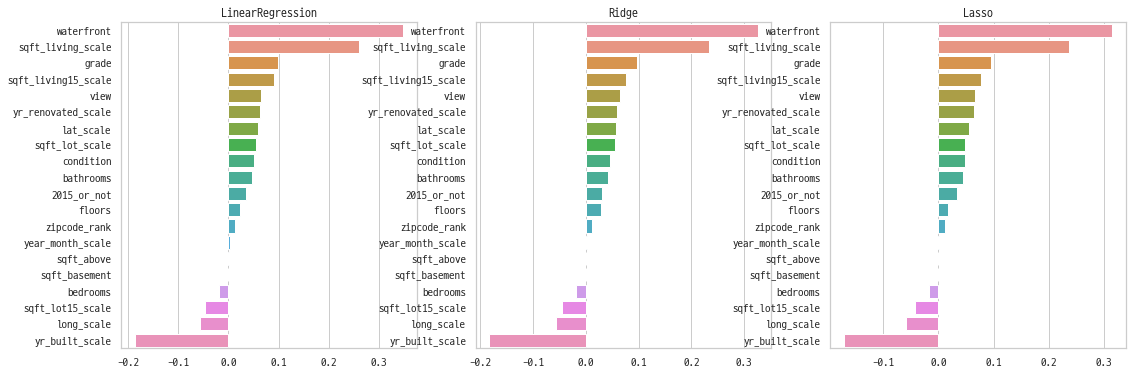

In [554]:
draw_coefs(models)

- 이제서야 Lasso도 Linear와 비슷한 성능을 보인다.. 하지만 lgbm에 비해서는 한참 떨어짐

In [555]:
X_sub = test[features]

In [556]:
linear.fit(train, label)
y_pred = linear.predict(X_sub)
y_pred

array([13.22972922, 13.09707265, 14.15731773, ..., 13.0515667 ,
       12.71180429, 13.0683531 ])

In [558]:
submission = LetSubmit(np.expm1(y_pred), "linear_tuning")
submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission: 147935